In [299]:
import pandas as pd
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV,TimeSeriesSplit,train_test_split,KFold,StratifiedKFold
import lightgbm as lgb
from xgboost import XGBRegressor
from rfpimp import *
from sklearn.metrics import mean_squared_error,mean_absolute_error,accuracy_score,f1_score
from math import sqrt
from sklearn.neighbors import KNeighborsClassifier
import numpy as np
from matplotlib_venn import venn2, venn2_circles
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer

In [300]:
df_train = pd.read_csv("training.csv")
df_test = pd.read_csv("testing.csv")

C:\Users\kjuneja\AppData\Local\Temp\ipykernel_19808\448774766.py:1: DtypeWarning: Columns (6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df_train = pd.read_csv("training.csv")


In [301]:
df_train['Kingdom'].nunique()

11

In [302]:
df_train['Kingdom'].value_counts()

bct    2298
vrl    2237
pln    1959
vrt    1636
inv    1064
mam     426
phg     172
rod     171
pri     143
arc      99
plm      13
Name: Kingdom, dtype: int64

In [303]:
df_train.drop('id', inplace = True, axis = 1)

In [304]:
#Function to check null values
def assess_NA(data):
    null_sum = data.isnull().sum()# instantiate columns for missing data
    total = null_sum.sort_values(ascending=False)
    percent = ( ((null_sum / len(data.index))*100).round(2) ).sort_values(ascending=False)
    
    df_NA = pd.concat([total, percent], axis=1, keys=['Number of NA', 'Percent NA'])
    
    df_NA = df_NA[ (df_NA.T != 0).any() ]
    
    return df_NA

In [305]:
assess_NA(df_train)

,Number of NA,Percent NA
DNAtype,1,0.01


In [306]:
encode_label = {
    ' bacteria' : 0,
    'virus' :10,
    'plant' : 5,
    'vertebrate' : 9,
    'invertebrate' : 3,
    'mammal' : 4,
    'bacteriophage' : 2,
    'rodent' : 8,
    'primate' : 7,
    'archaea' : 1,
    'plasmid' : 6
}

In [307]:
kindom_names = {'arc': 'archaea', 
          'bct': ' bacteria', 
          'phg' : 'bacteriophage', 
          'plm': 'plasmid',
          'pln': 'plant',
          'inv': 'invertebrate',
          'vrt': 'vertebrate',
          'mam': 'mammal',
          'rod': 'rodent',
          'pri': 'primate', 
          'vrl': 'virus'}

In [308]:
encode_label = {
    ' bacteria' : 0,
    'virus' :10,
    'plant' : 5,
    'vertebrate' : 9,
    'invertebrate' : 3,
    'mammal' : 4,
    'bacteriophage' : 2,
    'rodent' : 8,
    'primate' : 7,
    'archaea' : 1,
    'plasmid' : 6
}

In [309]:
df_train['Kingdom'] = df_train['Kingdom'].map(kindom_names)
df_train["Kingdom_encoded"] = df_train["Kingdom"].map(encode_label)

In [310]:
cols_rm = ['']

In [311]:
df_train['Kingdom_encoded'].value_counts()

0     2298
10    2237
5     1959
9     1636
3     1064
4      426
2      172
8      171
7      143
1       99
6       13
Name: Kingdom_encoded, dtype: int64

In [312]:
# codons = df_train.loc[:,df_train.columns[6:]]
# codons = codons[codons.columns[1:]]

In [313]:
df_train[df_train.columns[1:5]].nunique()

DNAtype           11
SpeciesID       9802
Ncodons         5976
SpeciesName    10210
dtype: int64

Text(0.5, 1.0, 'DNAtype')

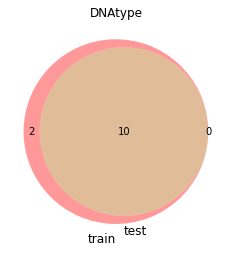

In [314]:
venn2([set(df_train['DNAtype'].values), set(df_test['DNAtype'].values)], set_labels = ('train','test'))
plt.title('DNAtype')

In [253]:
df_train['DNAtype'].value_counts()

0.0     7268
1.0     2235
2.0      631
4.0       36
5.0       17
3.0       12
6.0       10
12.0       4
11.0       2
7.0        1
9.0        1
Name: DNAtype, dtype: int64

In [254]:
df_test['DNAtype'].value_counts()

0     1954
1      633
2      194
4       17
6        4
5        3
3        2
9        1
12       1
7        1
Name: DNAtype, dtype: int64

In [255]:
df_train = df_train[df_train['DNAtype'] != 11.0]

In [256]:
df_train.reset_index(inplace=True,drop=True)
df_train['DNAtype'].fillna(0,inplace=True)

In [257]:
df_train['DNAtype'] = df_train['DNAtype'].astype(int)

In [258]:
df_train.shape,df_test.shape

((10216, 70), (2810, 69))

In [259]:
# for i in df_train.loc[:,df_train.columns[8:50]].columns:
#     print(i)
#     temp = df_train.groupby('DNAtype').agg({i:['sum','mean']})
#     temp.columns = ['_'.join(x) for x in temp.columns]
#     df_train = pd.merge(df_train,temp,on=['DNAtype'])
#     df_test = pd.merge(df_test,temp,on=['DNAtype'])

In [260]:
df_train

,Kingdom,DNAtype,SpeciesID,Ncodons,SpeciesName,UUU,UUC,UUA,UUG,CUU,...,AGA,AGG,GAU,GAC,GAA,GAG,UAA,UAG,UGA,Kingdom_encoded
0,plant,0,3886,4181,Phaseolus coccineus,0.02392,0.02966,0.00765,0.01794,0.01937,...,0.00789,0.01315,0.02966,0.02631,0.02822,0.02727,0.00096,0.00191,0.00144,5
1,archaea,0,146920,1716,Acidianus tengchongenses,0.01748,0.01049,0.05361,0.01282,0.01107,...,0.03322,0.00524,0.04429,0.01340,0.05769,0.02214,0.00233,0.00000,0.00000,1
2,virus,0,220938,1103,Tomato yellow leaf curl virus-[Almeria],0.02357,0.02267,0.01632,0.01088,0.01088,...,0.01995,0.01632,0.03083,0.01813,0.02992,0.01904,0.00363,0.00091,0.00091,10
3,plant,1,35128,9379,mitochondrion Thalassiosira pseudonana,0.0708,0.01397,0.07389,0.01685,0.01514,...,0.01386,0.00213,0.02143,0.00618,0.02506,0.00533,0.00341,0.00032,0.00661,5
4,rodent,1,9995,1520,mitochondrion Marmota monax,0.04671,0.02632,0.03421,0.00000,0.03882,...,0.00263,0.00000,0.01053,0.01842,0.01382,0.00197,0.00000,0.00000,0.02895,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10211,virus,0,390237,3057,White lupin mosaic virus,0.02781,0.01897,0.01505,0.02715,0.01636,...,0.02126,0.01505,0.03369,0.02126,0.03467,0.03042,0.00000,0.00033,0.00000,10
10212,virus,0,284687,3646,Amasya cherry disease associated chrysovirus,0.00905,0.01865,0.00521,0.02030,0.00933,...,0.01920,0.02935,0.03428,0.03209,0.03291,0.03922,0.00110,0.00000,0.00000,10
10213,plant,0,3721,1289,Crambe hispanica subsp. abyssinica,0.0256,0.0225,0.01164,0.01939,0.02870,...,0.01707,0.00155,0.02793,0.01707,0.01552,0.02560,0.00233,0.00000,0.00000,5
10214,plant,0,36902,11065,Medicago sativa subsp. x varia,0.02178,0.01663,0.01175,0.02332,0.02585,...,0.01654,0.01347,0.04058,0.01943,0.03145,0.02919,0.00117,0.00081,0.00081,5


In [261]:
df_test

,id,DNAtype,SpeciesID,Ncodons,SpeciesName,UUU,UUC,UUA,UUG,CUU,...,CGG,AGA,AGG,GAU,GAC,GAA,GAG,UAA,UAG,UGA
0,10129,0,380134,3307,Fusarium oxysporum f. sp. colocasiae,0.00907,0.03145,0.00121,0.01270,0.01391,...,0.00000,0.00423,0.00121,0.02873,0.03538,0.00544,0.01875,0.00121,0.00121,0.00000
1,10130,0,235457,1357,Adeno-associated virus 11,0.01695,0.02800,0.00368,0.00590,0.00368,...,0.00663,0.01400,0.00442,0.01179,0.04348,0.01548,0.04274,0.00147,0.00000,0.00000
2,10131,2,34301,26766,chloroplast Nymphaea alba,0.03172,0.02272,0.02798,0.02167,0.02062,...,0.00497,0.01939,0.00770,0.03262,0.00897,0.03852,0.01487,0.00164,0.00090,0.00097
3,10132,0,5530,30838,Metarhizium anisopliae,0.01235,0.02299,0.00311,0.01362,0.01443,...,0.00519,0.00538,0.00451,0.02396,0.03502,0.01647,0.03424,0.00104,0.00062,0.00032
4,10133,1,398797,2402,mitochondrion Rhagophthalmus lufengensis,0.09159,0.01166,0.10991,0.00833,0.01499,...,0.00083,0.02748,0.00000,0.01249,0.00083,0.01873,0.00250,0.00291,0.00125,0.02581
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2805,12934,0,35795,7802,Ehrlichia muris,0.05922,0.01397,0.03691,0.00974,0.01256,...,0.00026,0.01154,0.00500,0.03922,0.01025,0.03473,0.00948,0.00282,0.00090,0.00000
2806,12935,0,8673,9087,Pseudonaja textilis,0.01937,0.01717,0.00880,0.01519,0.01398,...,0.00220,0.01552,0.00902,0.03257,0.02487,0.03720,0.01805,0.00088,0.00143,0.00165
2807,12936,0,297249,1105,Tomato yellow leaf curl Guangdong virus,0.02443,0.01991,0.02262,0.01267,0.00905,...,0.00543,0.01900,0.01448,0.03710,0.00995,0.02805,0.02081,0.00362,0.00090,0.00090
2808,12937,0,73123,1654,Diaporthe ambigua,0.01270,0.03083,0.00423,0.02116,0.01511,...,0.00726,0.01088,0.01391,0.02781,0.03869,0.01935,0.03688,0.00000,0.00000,0.00121


In [262]:
set(df_train['DNAtype'].values)

{0, 1, 2, 3, 4, 5, 6, 7, 9, 12}

In [263]:
set(df_test['DNAtype'].values)

{0, 1, 2, 3, 4, 5, 6, 7, 9, 12}

Text(0.5, 1.0, 'SpeciesID')

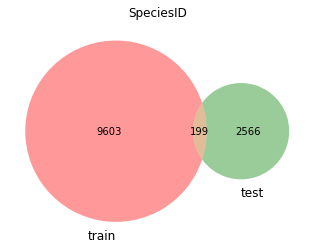

In [264]:
venn2([set(df_train['SpeciesID'].values), set(df_test['SpeciesID'].values)], set_labels = ('train','test'))
plt.title('SpeciesID')

Text(0.5, 1.0, 'Ncodons')

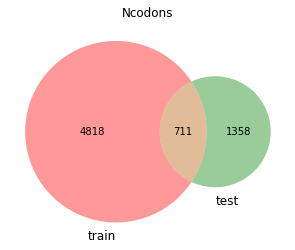

In [265]:
venn2([set(df_train['UUU'].values), set(df_test['UUU'].values)], set_labels = ('train','test'))
plt.title('Ncodons')

Text(0.5, 1.0, 'SpeciesName')

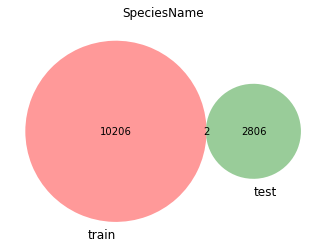

In [266]:
venn2([set(df_train['SpeciesName'].values), set(df_test['SpeciesName'].values)], set_labels = ('train','test'))
plt.title('SpeciesName')

In [315]:
df_train = pd.get_dummies(df_train,columns=['DNAtype'])
df_test = pd.get_dummies(df_test,columns=['DNAtype'])

In [268]:
df_test.shape,df_train.shape

((2810, 78), (10216, 79))

In [269]:
df_train

,Kingdom,SpeciesID,Ncodons,SpeciesName,UUU,UUC,UUA,UUG,CUU,CUC,...,DNAtype_0,DNAtype_1,DNAtype_2,DNAtype_3,DNAtype_4,DNAtype_5,DNAtype_6,DNAtype_7,DNAtype_9,DNAtype_12
0,plant,3886,4181,Phaseolus coccineus,0.02392,0.02966,0.00765,0.01794,0.01937,0.02392,...,1,0,0,0,0,0,0,0,0,0
1,archaea,146920,1716,Acidianus tengchongenses,0.01748,0.01049,0.05361,0.01282,0.01107,0.00117,...,1,0,0,0,0,0,0,0,0,0
2,virus,220938,1103,Tomato yellow leaf curl virus-[Almeria],0.02357,0.02267,0.01632,0.01088,0.01088,0.01269,...,1,0,0,0,0,0,0,0,0,0
3,plant,35128,9379,mitochondrion Thalassiosira pseudonana,0.0708,0.01397,0.07389,0.01685,0.01514,0.00117,...,0,1,0,0,0,0,0,0,0,0
4,rodent,9995,1520,mitochondrion Marmota monax,0.04671,0.02632,0.03421,0.00000,0.03882,0.02500,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10211,virus,390237,3057,White lupin mosaic virus,0.02781,0.01897,0.01505,0.02715,0.01636,0.01178,...,1,0,0,0,0,0,0,0,0,0
10212,virus,284687,3646,Amasya cherry disease associated chrysovirus,0.00905,0.01865,0.00521,0.02030,0.00933,0.00494,...,1,0,0,0,0,0,0,0,0,0
10213,plant,3721,1289,Crambe hispanica subsp. abyssinica,0.0256,0.0225,0.01164,0.01939,0.02870,0.01629,...,1,0,0,0,0,0,0,0,0,0
10214,plant,36902,11065,Medicago sativa subsp. x varia,0.02178,0.01663,0.01175,0.02332,0.02585,0.01157,...,1,0,0,0,0,0,0,0,0,0


In [270]:
# cols_rm = ['SpeciesID']
# df_train.drop(cols_rm,axis=1,inplace=True)
# df_test.drop(cols_rm,axis=1,inplace=True)

In [271]:
df_train['UUU'] = pd.to_numeric(df_train['UUU'],errors='coerce')
# df_train['UUC'] = pd.to_numeric(df_train['UUC'],errors='coerce')

df_test['UUU'] = pd.to_numeric(df_test['UUU'],errors='coerce')
# df_test['UUC'] = pd.to_numeric(df_test['UUC'],errors='coerce')

In [272]:
# # df_train.drop(['Kingdom', 'UUU', 'UUC'],axis=1,inplace=True)
# df_test.drop(['UUU', 'UUC'],axis=1,inplace=True)

In [273]:
cumulative_sum = df_train.groupby('Ncodons')["Kingdom_encoded"].cumsum() - df_train["Kingdom_encoded"]
cumulative_count = df_train.groupby('Ncodons').cumcount()
df_train['Ncodons' + "_mean_target"] = cumulative_sum/cumulative_count

vals = df_train.groupby('Ncodons').agg({'Kingdom_encoded':['mean']})
vals.columns = [x[0] for x in vals.columns]
vals.rename(columns={'Kingdom_encoded':'Ncodons_mean_target'},inplace=True)

df_test = pd.merge(df_test,vals,on='Ncodons',how='left')
df_train.drop(['Ncodons'],axis=1,inplace=True)
df_test.drop(['Ncodons'],axis=1,inplace=True)

In [274]:
cumulative_sum = df_train.groupby('SpeciesID')["Kingdom_encoded"].cumsum() - df_train["Kingdom_encoded"]
cumulative_count = df_train.groupby('SpeciesID').cumcount()
df_train['SpeciesID' + "_mean_target"] = cumulative_sum/cumulative_count

vals = df_train.groupby('SpeciesID').agg({'Kingdom_encoded':['mean']})
vals.columns = [x[0] for x in vals.columns]
vals.rename(columns={'Kingdom_encoded':'SpeciesID_mean_target'},inplace=True)

df_test = pd.merge(df_test,vals,on='SpeciesID',how='left')
df_train.drop(['SpeciesID','Kingdom'],axis=1,inplace=True)
df_test.drop(['SpeciesID'],axis=1,inplace=True)

In [275]:
cumulative_sum = df_train.groupby('UUU')["Kingdom_encoded"].cumsum() - df_train["Kingdom_encoded"]
cumulative_count = df_train.groupby('UUU').cumcount()
df_train['UUU' + "_mean_target"] = cumulative_sum/cumulative_count

vals = df_train.groupby('UUU').agg({'Kingdom_encoded':['mean']})
vals.columns = [x[0] for x in vals.columns]
vals.rename(columns={'Kingdom_encoded':'UUU_mean_target'},inplace=True)

df_test = pd.merge(df_test,vals,on='UUU',how='left')
df_train.drop(['UUU'],axis=1,inplace=True)
df_test.drop(['UUU'],axis=1,inplace=True)

In [276]:
df_test.shape

(2810, 78)

In [277]:
tf = TfidfVectorizer()
train_vector = tf.fit_transform(df_train['SpeciesName'])
train_vector = pd.DataFrame(train_vector.toarray(), columns = tf.get_feature_names())
test_vector = tf.transform(df_test['SpeciesName'])
test_vector = pd.DataFrame(test_vector.toarray(), columns = tf.get_feature_names())

C:\Users\kjuneja\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
C:\Users\kjuneja\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [278]:
cvec = CountVectorizer()
train_vector_cvec = cvec.fit_transform(df_train['SpeciesName'])

In [279]:
cols = []
for i in cvec.get_feature_names():
    cols.append(i+'_cvec')

C:\Users\kjuneja\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [280]:
train_vector_cvec = pd.DataFrame(train_vector_cvec.toarray(), columns=cols)
test_vector_cvec = cvec.transform(df_test['SpeciesName'])
test_vector_cvec = pd.DataFrame(test_vector_cvec.toarray(), columns=cols)

In [281]:
df_train = pd.concat([df_train,train_vector],axis=1)
df_test = pd.concat([df_test,test_vector],axis=1)
df_train = pd.concat([df_train,train_vector_cvec],axis=1)
df_test = pd.concat([df_test,test_vector_cvec],axis=1)

In [282]:
df_train.drop(['SpeciesName','UUC'],axis=1,inplace=True)
df_test.drop(['SpeciesName','UUC'],axis=1,inplace=True)

In [283]:
# y = df_train['Kingdom_encoded']

In [284]:
df_train.columns

Index(['UUA', 'UUG', 'CUU', 'CUC', 'CUA', 'CUG', 'AUU', 'AUC', 'AUA', 'AUG',
       ...
       'zonotrichia_cvec', 'zooepidemicus_cvec', 'zootoca_cvec',
       'zostera_cvec', 'zosterops_cvec', 'zoym_cvec', 'zucchini_cvec',
       'zw_cvec', 'zygosaccharomyces_cvec', 'zymomonas_cvec'],
      dtype='object', length=22904)

In [285]:
df_test.columns

Index(['id', 'UUA', 'UUG', 'CUU', 'CUC', 'CUA', 'CUG', 'AUU', 'AUC', 'AUA',
       ...
       'zonotrichia_cvec', 'zooepidemicus_cvec', 'zootoca_cvec',
       'zostera_cvec', 'zosterops_cvec', 'zoym_cvec', 'zucchini_cvec',
       'zw_cvec', 'zygosaccharomyces_cvec', 'zymomonas_cvec'],
      dtype='object', length=22904)

In [286]:
set(df_train.columns) ^ set(df_test.columns)

{'Kingdom_encoded', 'id'}

In [287]:
# Creating and holdout set and train 
# X_train,X_valid,y_train,y_valid = train_test_split(df_train.drop(['Kingdom_encoded'],axis=1),df_train['Kingdom_encoded'],random_state=22,test_size=0.20,stratify=df_train['Kingdom_encoded'])

In [288]:
y = df_train['Kingdom_encoded']

In [289]:
def evaluate_F1_lgb(truth,predictions):
    pred_labels = np.round(predictions)
    f1=f1_score(truth,pred_labels)
    return ('F1', f1, True)

In [290]:
X_train.shape

NameError: name 'X_train' is not defined

In [291]:
y_train.shape

NameError: name 'y_train' is not defined

In [292]:
df_train.drop('Kingdom_encoded',axis=1,inplace=True)

In [ ]:
splits = 7
folds = StratifiedKFold(n_splits=splits, shuffle=True, random_state=22)
# predictions = np.zeros((len(X_valid),11))
oof_preds = np.zeros((len(df_test), 11))
final_preds = []
for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train, y)):
        print("Fold {}".format(fold_))
        X_trn,y_trn = df_train.iloc[trn_idx],y.iloc[trn_idx]
        X_val,y_val = df_train.iloc[val_idx],y.iloc[val_idx]
        clf = lgb.LGBMClassifier(random_state=22,n_jobs=-1,learning_rate=0.1,n_estimators=5000,is_unbalance=True)
        clf.fit(X_trn, y_trn, eval_metric='multi_logloss', eval_set=[(X_val,y_val)], verbose=True,early_stopping_rounds=100)
        
        y_val_preds = clf.predict_proba(X_val)
        final_preds.append(f1_score(y_pred=[np.argmax(x) for x in y_val_preds],y_true=y_val,average='weighted'))
#         predictions += clf.predict_proba(X_valid)
        oof_preds += clf.predict_proba(df_test.drop('id',axis=1))
#         counter = counter + 1
oof_preds = oof_preds/splits
print(sum(final_preds)/splits)

In [ ]:
# predictions = predictions/splits

In [ ]:
Counter([np.argmax(x) for x in predictions])

In [ ]:
print(f"F1_score for validation : {f1_score(y_pred=[np.argmax(x) for x in predictions],y_true=y_valid,average='weighted')}")
print(f"accuracy_score for validation : {accuracy_score(y_pred=[np.argmax(x) for x in predictions],y_true=y_valid)}")

In [293]:
#final model
clf = lgb.LGBMClassifier(random_state=22,n_jobs=-1,learning_rate=0.1,n_estimators=700,is_unbalance=True,num_leaves=40)
clf.fit(df_train,y)
preds = clf.predict_proba(df_test.drop('id',axis=1))

In [294]:
rev_kindom = {v: k for k, v in kindom_names.items()}
rev_encode = {v: k for k, v in encode_label.items()}

In [295]:
df_test['preds'] = [np.argmax(x) for x in preds]

In [296]:
df_test['preds'] = df_test['preds'].map(rev_encode)
df_test['preds'] = df_test['preds'].map(rev_kindom)

In [297]:
df_sub = df_test[['id','preds']]
df_sub.rename(columns={'preds':'Kingdom'},inplace=True)
df_sub.to_csv('full_data.csv',index=False)

C:\Users\kjuneja\AppData\Local\Temp\ipykernel_19808\1005359201.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub.rename(columns={'preds':'Kingdom'},inplace=True)


In [298]:
df_test['preds'].value_counts()

bct    626
vrl    594
pln    582
vrt    452
inv    262
mam    144
phg     57
pri     35
rod     34
arc     19
plm      5
Name: preds, dtype: int64